In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import roc_auc_score
from copy import deepcopy

In [ ]:
# scikit-learn에서 데이터셋 받아오고 확인하기

cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['class'] = cancer.target

In [3]:
# 데이터 준비
data = torch.from_numpy(df.values).float()

x = data[:, :-1]    # 마지막 행을 제외한 행들을 x로 설정
y = data[:, -1:]    # 마지막 행만 y로 설정

print(x.shape, y.shape)

torch.Size([569, 30]) torch.Size([569, 1])


In [ ]:
# 학습, 검증, 테스트 데이터 분할 비율 정의
ratios = [0.6, 0.2, 0.2]

train_cnt = int(data.size(0) * ratios[0])
val_cnt = int(data.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - val_cnt
cnts = [train_cnt, val_cnt, test_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, val_cnt, test_cnt))

Train 341 / Valid 113 / Test 115 samples.


In [ ]:
# 데이터 분할

# 데이터 섞기

indices = torch.randperm(data.size(0))
x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

# 데이터를 학습/검증/테스트로 분할
x = list(x.split(cnts, dim=0))
y = y.split(cnts, dim=0)

# 각 분할된 데이터 크기 확인
for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

torch.Size([341, 30]) torch.Size([341, 1])
torch.Size([113, 30]) torch.Size([113, 1])
torch.Size([115, 30]) torch.Size([115, 1])


In [ ]:
# 학습 데이터 기준으로 정규화

scaler = StandardScaler()
scaler.fit(x[0].numpy())

print(x[1][:5])

x = [torch.from_numpy(scaler.transform(x[0].numpy())).float(),
        torch.from_numpy(scaler.transform(x[1].numpy())).float(),
        torch.from_numpy(scaler.transform(x[2].numpy())).float()]

print(x[1][:5])

tensor([[1.3300e+01, 2.1570e+01, 8.5240e+01, 5.4610e+02, 8.5820e-02, 6.3730e-02,
         3.3440e-02, 2.4240e-02, 1.8150e-01, 5.6960e-02, 2.6210e-01, 1.5390e+00,
         2.0280e+00, 2.0980e+01, 5.4980e-03, 2.0450e-02, 1.7950e-02, 6.3990e-03,
         1.8290e-02, 1.9560e-03, 1.4200e+01, 2.9200e+01, 9.2940e+01, 6.2120e+02,
         1.1400e-01, 1.6670e-01, 1.2120e-01, 5.6140e-02, 2.6370e-01, 6.6580e-02],
        [9.5670e+00, 1.5910e+01, 6.0210e+01, 2.7960e+02, 8.4640e-02, 4.0870e-02,
         1.6520e-02, 1.6670e-02, 1.5510e-01, 6.4030e-02, 2.1520e-01, 8.3010e-01,
         1.2150e+00, 1.2640e+01, 1.1640e-02, 1.0400e-02, 1.1860e-02, 9.6230e-03,
         2.3830e-02, 3.5400e-03, 1.0510e+01, 1.9160e+01, 6.5740e+01, 3.3590e+02,
         1.5040e-01, 9.5150e-02, 7.1610e-02, 7.2220e-02, 2.7570e-01, 8.1780e-02],
        [1.5120e+01, 1.6680e+01, 9.8780e+01, 7.1660e+02, 8.8760e-02, 9.5880e-02,
         7.5500e-02, 4.0790e-02, 1.5940e-01, 5.9860e-02, 2.7110e-01, 3.6210e-01,
         1.9740e+00, 2.644

In [ ]:
# 모델 정의

model = nn.Sequential(
    nn.Linear(x[0].size(-1), 25),
    nn.LeakyReLU(),
    nn.Linear(25, 20),
    nn.LeakyReLU(),
    nn.Linear(20, 15),
    nn.LeakyReLU(),
    nn.Linear(15, 10),
    nn.LeakyReLU(),
    nn.Linear(10, 5),
    nn.LeakyReLU(),
    nn.Linear(5, y[0].size(-1)),
    nn.Sigmoid()
)

print(model)
optimizer = optim.Adam(model.parameters()) # 옵티마이저 함수로 Adam 사용, 학습률 필요 X

# 학습 설정
epochs = 10000          # 학습 반복 횟수
batch_size = 32         # 배치 사이즈
interval = 10           # 학습 결과를 출력할 간격
early_stop = 100        # 성능이 나아지지 않을 때, 몇 번까지 더 기다릴지 정하는 값
lowest_loss = np.inf    # 최소 검증 손실
best_model = None       # 최소 검증 손실을 기록한 모델
lowest_epoch = np.inf   # 최소 검증 손실을 기록할 epoch 번호

Sequential(
  (0): Linear(in_features=30, out_features=25, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=25, out_features=20, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=20, out_features=15, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=15, out_features=10, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=10, out_features=5, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=5, out_features=1, bias=True)
  (11): Sigmoid()
)


In [ ]:
# 모델 학습
train_history, val_history = [], []

for i in range(epochs):
    # 데이터 섞기 (무작위 인덱스 생성)
    indices = torch.randperm(x[0].size(0))

    # 입력 데이터와 정답 레이블을 같은 순서로 섞음
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)

    # 미니 배치로 분할
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    train_loss, val_loss = 0, 0         # 학습, 검증 손실 값
    y_hat = []                          # 예측값을 저장할 리스트

    # 각 미니 배치에 대해 학습
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)                        # 모델 예측값 계산
        loss = F.binary_cross_entropy(y_hat_i, y_i) # BCE 손실 계산

        optimizer.zero_grad()           # 기울기 초기화
        loss.backward()                 # 역전파로 기울기 계산
        optimizer.step()                # 가중치 업데이트

        train_loss += float(loss)       # 손실 누적
        
    train_loss /= len(x_)               # epoch별 평균 손실 계산

    # 검증 단계 (기울기 미계산)
    with torch.no_grad():
        # 검증 데이터를 미니 배치로 분할
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        val_loss = 0

        # 각 미니 배치에 대해 검증 수행
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)                        # 예측 결과 계산
            loss = F.binary_cross_entropy(y_hat_i, y_i) # BCE 손실 계산

            val_loss += loss                            # 배치 손실 값 누적
            y_hat += [y_hat_i]                          # 예측 결과를 리스트에 저장
    
    val_loss /= len(x_)                                 # 평균 검증 손실 계산

    # 손실 기록
    train_history += [train_loss]
    val_history += [val_loss]

    # 일정 간격으로 손실 출력
    if (i + 1) % interval == 0:
        print('Epoch %d: train loss = %.4e    val loss = %.4e   lowest loss = %.4e' % (i + 1, train_loss, val_loss, lowest_loss))
    
    # 모델 저장 조건
    if val_loss <= lowest_loss:                     # 현재 검증 손실이 이전까지의 최소 손실보다 작거나 같다면:
        lowest_loss = val_loss                      # 최소 손실값 갱신
        lowest_epoch = i                            # 해당 에폭 번호 저장
        best_model = deepcopy(model.state_dict())   # 현재 모델 복사 저장
    else:
        # 조기 종료 조건 확인 (early_stop만큼의 에폭이 지나도록 개선이 없으면)
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break                                   # 학습 조기 종료

# 최적 모델 결과 출력 및 로드
print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model)

Epoch 10: train loss = 4.0454e-01    val loss = 3.9751e-01   lowest loss = 4.7492e-01
Epoch 20: train loss = 4.2018e-02    val loss = 7.6832e-02   lowest loss = 7.0644e-02
Epoch 30: train loss = 3.0835e-02    val loss = 1.0419e-01   lowest loss = 7.0644e-02
Epoch 40: train loss = 2.4574e-02    val loss = 1.4167e-01   lowest loss = 7.0644e-02
Epoch 50: train loss = 1.7232e-02    val loss = 1.3616e-01   lowest loss = 7.0644e-02
Epoch 60: train loss = 1.3199e-02    val loss = 1.2170e-01   lowest loss = 7.0644e-02
Epoch 70: train loss = 2.8602e-03    val loss = 1.6040e-01   lowest loss = 7.0644e-02
Epoch 80: train loss = 8.2277e-04    val loss = 1.9051e-01   lowest loss = 7.0644e-02
Epoch 90: train loss = 4.8802e-04    val loss = 2.0563e-01   lowest loss = 7.0644e-02
Epoch 100: train loss = 2.5234e-04    val loss = 2.2172e-01   lowest loss = 7.0644e-02
Epoch 110: train loss = 1.7307e-04    val loss = 2.3847e-01   lowest loss = 7.0644e-02
There is no improvement during last 100 epochs.
The 

<All keys matched successfully>

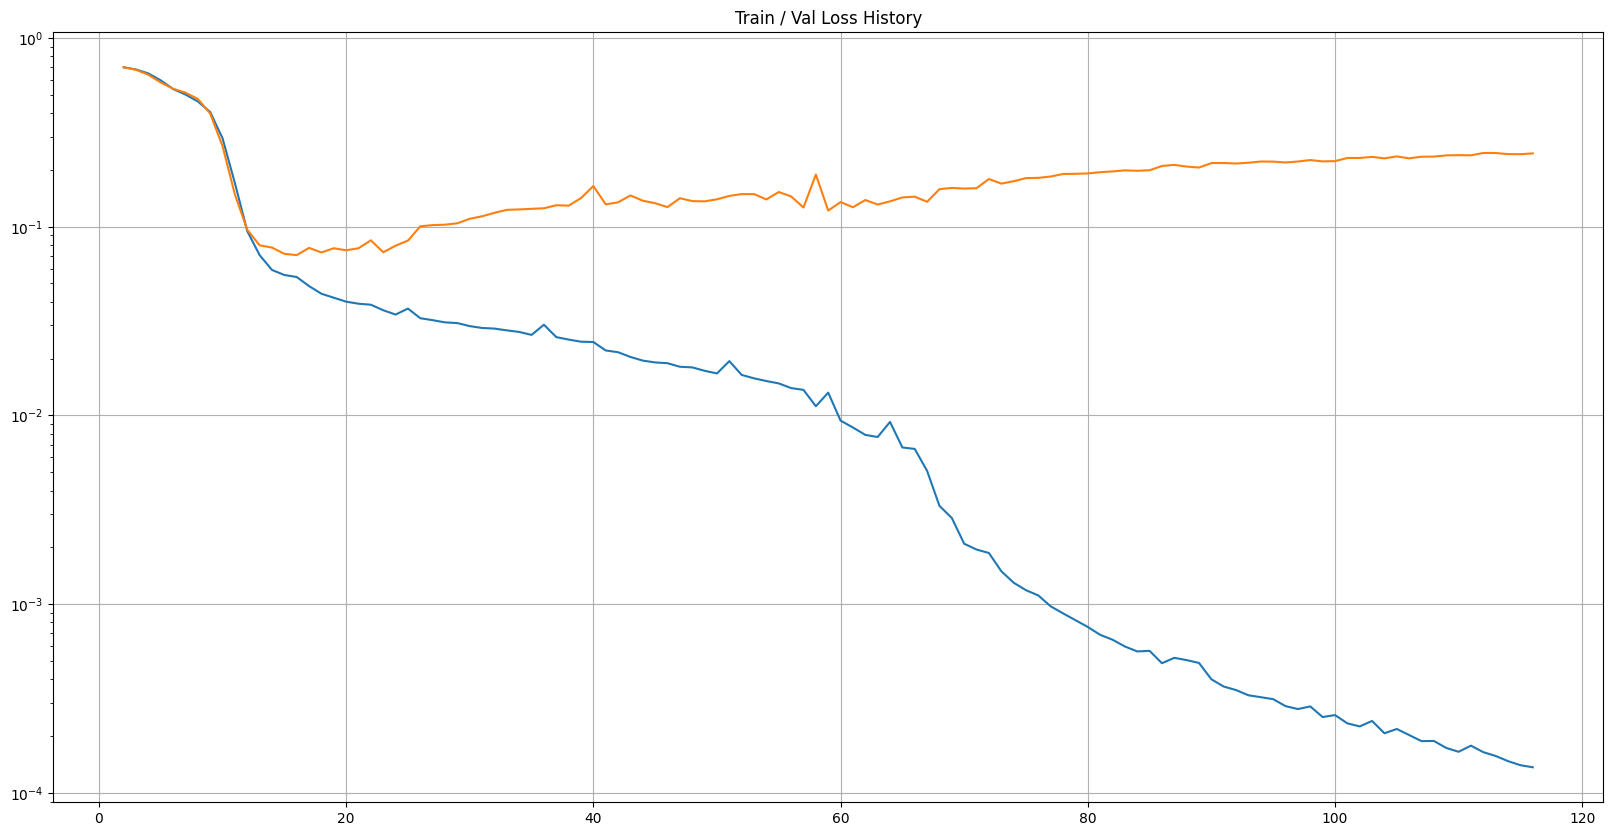

In [9]:
# 결과 시각화

plot_from = 2

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Val Loss History")

plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(val_history)), val_history[plot_from:],
)

plt.yscale('log')
plt.show()

In [ ]:
# 테스트 평가

test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)

        test_loss += loss
        y_hat += [y_hat_i]

test_loss /= len(x_)                # 평균 테스트 손실
y_hat = torch.cat(y_hat, dim=0)     # 전체 예측 결과 병합

# 가장 낮은 검증 손실 기준으로 출력
sorted_history = sorted(zip(train_history, val_history), key=lambda x: x[1])
print("Train loss: %.4e" % sorted_history[0][0])
print("Val loss: %.4e" % sorted_history[0][1])
print("Test loss: %.4e" % test_loss)

Train loss: 5.4096e-02
Val loss: 7.0644e-02
Test loss: 6.5511e-02


In [ ]:
# 정확도 확인

correct_cnt = (y[2] == (y_hat > 0.5)).sum()
total_cnt = float(y[2].size(0))

print('Test Accuracy: %.4f' % (correct_cnt / total_cnt))

Test Accuracy: 0.9826


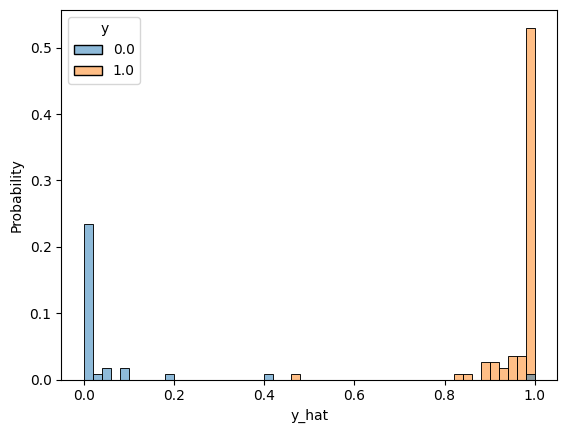

In [ ]:
# 결과 시각화

df = pd.DataFrame(torch.cat([y[2], y_hat], dim=1).detach().numpy(), columns=["y", "y_hat"])

sns.histplot(df, x='y_hat', hue='y', bins=50, stat='probability')
plt.show()

In [ ]:
# AUROC 확인

print(roc_auc_score(df.values[:, 0], df.values[:, 1]))

0.9903571428571428
